In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
pd.set_option('display.width', 200) 

In [4]:
data = pd.read_csv('../data/exon_classification.csv')
print(data.head())
print(data.shape)

        geneName       name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165   chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166   chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   
2  0610009B22Rik  NM_025319  chr11      -  51576211  51579461  51576473  51576896          2                               [51576211, 51579374]                               [51576919, 51579461]   
3  0610009E02Rik  NR_152208   chr2      +  26335935  26348007  26348007  26348007          2                               [26335935, 26347684]                               [26336212, 26348007]   
4  0610009

そもそも元データの時点で重複が存在する

In [9]:
refflat = pd.read_csv(
    "../data/refFlat.txt",
    sep="\t",
    header=None,
    names=[
        "geneName",
        "name",
        "chrom",
        "strand",
        "txStart",
        "txEnd",
        "cdsStart",
        "cdsEnd",
        "exonCount",
        "exonStarts",
        "exonEnds"])
print(refflat["name"].duplicated().sum())

1796


In [ ]:
duplicates = refflat[refflat.duplicated(subset=["name"], keep=False)]
print(duplicates)

In [12]:
refflat[refflat["geneName"] == "Ttn"]

,geneName,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds
23064,Ttn,NM_011652,chr2,-,76534327,76812891,76535374,76810526,313,"76534327,76536013,76536783,76537040,76538502,7...","76535673,76536316,76536937,76537732,76538659,7..."
23065,Ttn,NM_028004,chr2,-,76534327,76812891,76535374,76810526,192,"76534327,76536013,76536783,76537040,76538502,7...","76535673,76536316,76536937,76537732,76538659,7..."
47739,Ttn,NM_001385708,chr2,-,76534325,76812890,76535374,76810526,349,"76534325,76536013,76536783,76537040,76538502,7...","76535673,76536316,76536937,76537732,76538659,7..."


トータル遺伝子を数える  
元データと加工データの列数は同じ。

In [7]:
print(refflat["geneName"].nunique())
print(refflat.shape)

26264
(47741, 11)


In [5]:
print(data["geneName"].nunique())
print(data.shape)

26264
(47741, 14)


重複を削除し、トータル遺伝子数を再計測  
重複分だけ列数が減少

In [9]:
data = data.drop_duplicates(subset=["name"])
print(data["geneName"].nunique())
print(data.shape)

26264
(45945, 14)


遺伝子ごとにグループ化し、遺伝子あたりのスプライシングバリアント数をカウント

In [10]:
variant_counts = data.groupby("geneName")["name"].nunique().reset_index()
variant_counts.columns = ["geneName", "variant_count"]
print(variant_counts.head())

        geneName  variant_count
0  0610005C13Rik              2
1  0610009B22Rik              1
2  0610009E02Rik              3
3  0610009L18Rik              1
4  0610010F05Rik              3


バリアント数をdataに加える

In [11]:
data = data.merge(variant_counts, on="geneName", how="left")
print(data.head(6))

        geneName       name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165   chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166   chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   
2  0610009B22Rik  NM_025319  chr11      -  51576211  51579461  51576473  51576896          2                               [51576211, 51579374]                               [51576919, 51579461]   
3  0610009E02Rik  NR_152208   chr2      +  26335935  26348007  26348007  26348007          2                               [26335935, 26347684]                               [26336212, 26348007]   
4  0610009

cdsStart = cdsEndの場合はnon-coding, 異なる場合はcodingと定義し、"coding"列にデータを加える

In [12]:
data["coding"] =""
data.loc[data["cdsStart"] == data["cdsEnd"], "coding"] = "non-coding"
data.loc[data["cdsStart"] != data["cdsEnd"], "coding"] = "coding"
print(data["coding"].value_counts())
data["coding"] = data["coding"].astype("category")

coding
coding        38037
non-coding     7908
Name: count, dtype: int64


全ての遺伝子について、バリアント数の分布を可視化

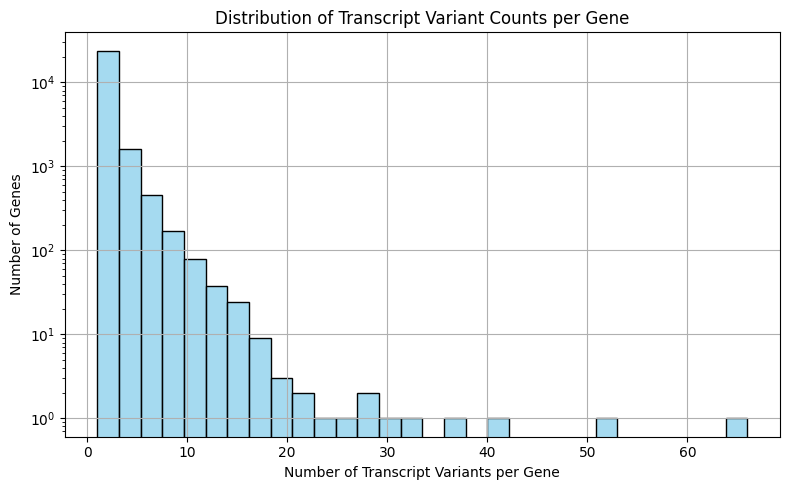

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(variant_counts["variant_count"], bins=30, kde=False, color="skyblue")

plt.xlabel("Number of Transcript Variants per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Transcript Variant Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [14]:
top_5_variant_counts = variant_counts.nlargest(5, "variant_count")
print(top_5_variant_counts)

      geneName  variant_count
4559     Celf4             66
2886    Arpp21             51
9682   Gm32817             40
15242     Mlip             36
3330      Bag6             33


In [20]:
print(data[data["geneName"] == "Celf4"].head(10))

     geneName          name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
7801    Celf4  NM_001362337  chr18      -  25610676  25812805  25619894  25670812         13  [25610676, 25619850, 25624197, 25629278, 25630...  [25612768, 25620022, 25624281, 25629362, 25630...   
7802    Celf4  NM_001146292  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624137, 25629278, 25630...  [25612768, 25620022, 25624281, 25629359, 25630...   
7803    Celf4  NM_001146293  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624197, 25629278, 25630...  [25612768, 25620022, 25624281, 25629359, 25630...   
7804    Celf4  NM_001146294  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624137, 25629278, 25630...  [25612768, 25620022, 25624281, 25629362, 25630...   
7805    Ce

遺伝子ごとに最大のエキソン数と、バリアント数の関係を散布図で示す

In [15]:
exon_counts = refflat.groupby("geneName")["exonCount"].max().reset_index()
exon_counts.columns = ["geneName", "max_exon_count"]
print(exon_counts.head())

        geneName  max_exon_count
0  0610005C13Rik               5
1  0610009B22Rik               2
2  0610009E02Rik               3
3  0610009L18Rik               2
4  0610010F05Rik              23


In [25]:
data = data.merge(exon_counts, on="geneName", how="left")
print(data.head(2))

        geneName       name chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165  chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166  chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   

                exonlengths                                              exons                                           exontype  variant_count      coding  max_exon_count  
0       [585, 110, 170, 50]  [(45217218, 45217803), (45223836, 45223946), (...  ['constitutive', 'constitutive', 'constitutive...              2  non-coding               5  
1  [585, 207, 110, 170, 50]  [(45217218, 45217803), (45220

In [16]:
summary = exon_counts.merge(
    variant_counts, on="geneName", how="left"
).merge(
    data[["geneName", "coding"]].drop_duplicates(),
    on="geneName",
    how="left"
)
print(summary.head())

        geneName  max_exon_count  variant_count      coding
0  0610005C13Rik               5              2  non-coding
1  0610009B22Rik               2              1      coding
2  0610009E02Rik               3              3  non-coding
3  0610009L18Rik               2              1  non-coding
4  0610010F05Rik              23              3  non-coding


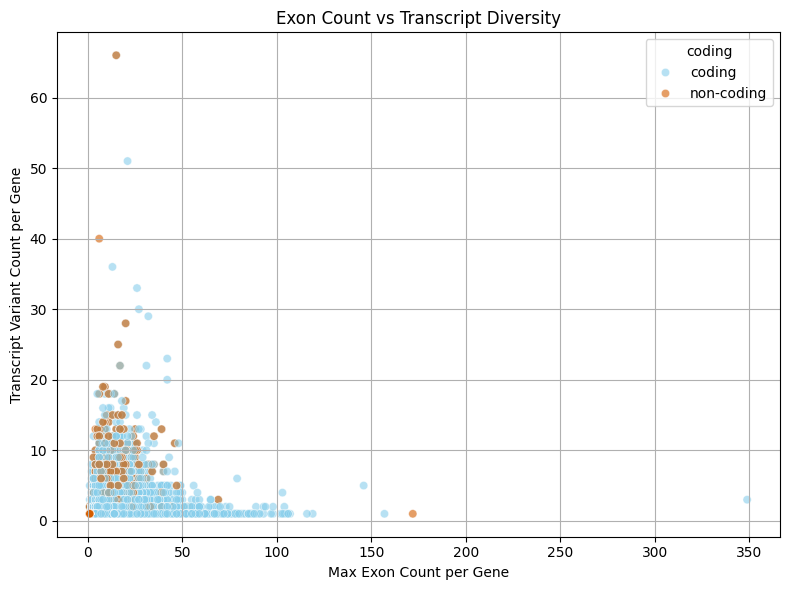

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary,
    x="max_exon_count",
    y="variant_count",
    alpha=0.6,
    hue="coding",
    palette={"coding": "skyblue", "non-coding": "#D55E00"},
)

plt.xlabel("Max Exon Count per Gene")
plt.ylabel("Transcript Variant Count per Gene")
plt.title("Exon Count vs Transcript Diversity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
top_5_exon_counts = summary.nlargest(5, "max_exon_count")
print(top_5_exon_counts)

      geneName  max_exon_count  variant_count      coding
25516      Ttn             349              3      coding
22987   Snhg14             172              1  non-coding
16692      Neb             157              1      coding
23898    Syne1             146              5      coding
5411    Col7a1             119              1      coding


In [ ]:
print(data["chrom"].value_counts())

chrom
chr2                      3974
chr7                      3785
chr11                     3479
chr4                      2806
chr5                      2769
chr9                      2557
chr1                      2544
chr6                      2406
chr8                      2310
chr17                     2270
chr3                      2225
chr10                     2187
chrX                      1872
chr14                     1681
chr15                     1679
chr13                     1603
chr12                     1591
chr19                     1505
chr16                     1431
chr18                     1156
chrY                       101
chrX_GL456233v2_random       6
chr1_GL456212v1_random       3
chr1_GL456221v1_random       2
chr1_MU069434v1_random       1
chr1_GL456211v1_random       1
chrUn_JH584304v1             1
Name: count, dtype: int64


In [28]:
data.to_csv("../data/exon_classification_cleaned.csv", index=False)